In [1]:
from single_cell_model_cal2 import SingleCellCalciumModelCaL2
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint 

In [2]:
T = 20
dt = 0.0001

In [19]:
class SingleCellCalciumModelIPR2(SingleCellCalciumModelCaL2):
    
    def __init__(self):
        super().__init__()
        self.g_cal = 1
        self.time = np.linspace(0, T, int(T/dt))
        self.v_ip3r = 50
#         self.k_3 = 20
        self.k_a = 0.15
        self.k_ip = 0.1
        self.k_i = 0.2
        self.k_6 = 4
        self.r0 = 0.941
    
    def i_ip3r(self, c, c_t, r, ip):
        return (self.v_ip3r * r * c**2 * ip**2\
                / (self.k_a**2 + c**2) / (self.k_ip**2 + ip **2))\
                * ((c_t-c)*self.gamma - c)
    
    def i_serca(self, c):
        v_serca =  40 
        k_serca = 0.1 
        return v_serca * c / (c + k_serca)
    
    def i_leak(self, c, c_t):
        v_leak = (- self.i_ip3r(self.c0, self.ct0, self.r0, self.ip0) \
                  + self.i_serca(self.c0)) \
                  / ((self.ct0-self.c0)*self.gamma - self.c0)
        
        return v_leak * ((c_t-c)*self.gamma - c)
    
    def i_pmca(self, c):
        k_pmca =  1.5
        v_pmca = 200
        return v_pmca * c**2 / (k_pmca**2 + c**2)
    
    def i_r(self, c, r):
        return self.k_6 * (self.k_i**2 / (self.k_i**2 + c**2) - r)
    
    def rhs(self, y, t):
        c, c_t, r, ip, v, m, h, n, m_cal, h_cal = y
    
        dcdt = 1.0 * ((self.i_ip3r(c, c_t, r, ip) \
             - self.i_serca(c) \
             + self.i_leak(c, c_t)) \
             + (- self.i_pmca(c) \
                - self.i_cal(v, m_cal, h_cal) \
                + self.i_soc(c, c_t) \
                - self.i_out(c)) * self.delta)
        
        dctdt = 1.0 * (- self.i_pmca(c) \
                       - self.i_cal(v, m_cal, h_cal) \
                       + self.i_soc(c, c_t) \
                       - self.i_out(c))\
                 * self.delta

        drdt =  1.0 * self.i_r(c, r)

        dipdt = 0

        dvdt = - (self.i_na(v,m,h) \
                  + self.i_k(v,n) \
                  + self.i_bk(v) \
                  + 2*self.i_cal(v, m_cal, h_cal)\
                  - self.stim(t))/self.c_m
        
        dmdt = self.alpha_m(v) * (1-m) - self.beta_m(v) * m
        dhdt = self.alpha_h(v) * (1-h) - self.beta_h(v) * h
        dndt = self.alpha_n(v) * (1-n) - self.beta_n(v) * n
        dmcaldt = (self.m_cal_inf(v) - m_cal) / self.tau_cal_m(v)
        dhcaldt = (self.h_cal_inf(v) - h_cal) / self.tau_cal_h(v)
        
        return [dcdt, dctdt, drdt, dipdt, dvdt, dmdt, dhdt, dndt, dmcaldt, dhcaldt]
    
    # Override
    def step(self):
        self.hh0 = self.hh_inf(self.c0, self.ip0)
        
        y0 = [self.c0, self.ct0, self.r0, self.ip0,
              self.v0, self.m0, self.h0, self.n0, self.m_cal0, self.h_cal0]
        sol = odeint(self.rhs, y0, self.time, hmax = 0.005)
        return sol

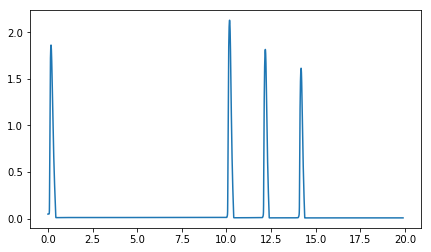

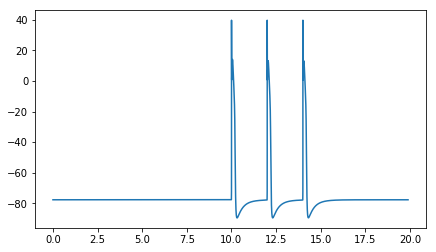

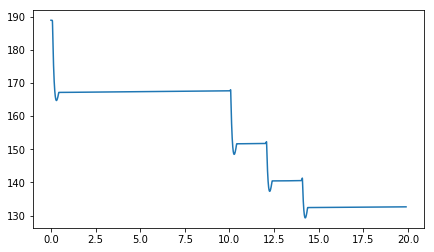

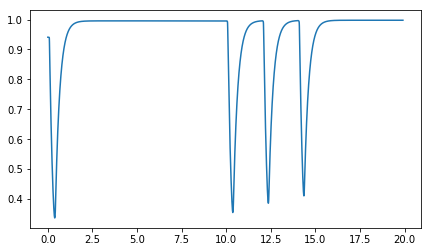

In [20]:
if __name__ == "__main__":
    model = SingleCellCalciumModelIPR2()
    sol = model.step()
    c = sol[:,0]
    c_t = sol[:,1]
    r = sol[:,2]
    ip = sol[:,3]
    v = sol[:,4]
    m = sol[:,5]
    h = sol[:,6]
    n = sol[:,7]
    m_cal = sol[:,8]
    h_cal = sol[:,9]
    model.plot(c)
    model.plot(v)
    model.plot((c_t - c)*model.gamma)
    model.plot(r)

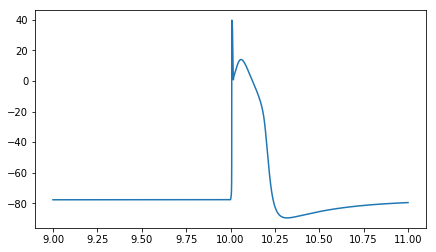

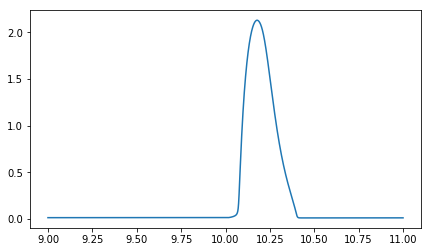

In [21]:
# plt.plot(model.time, FluorescenceEncoder(c).step())
# plt.show()
model.plot(v, 90, 110)
model.plot(c, 90, 110)

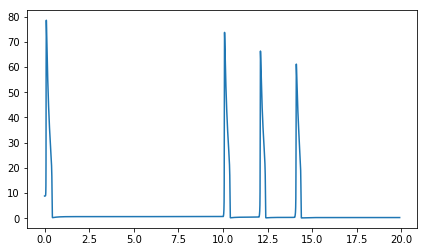

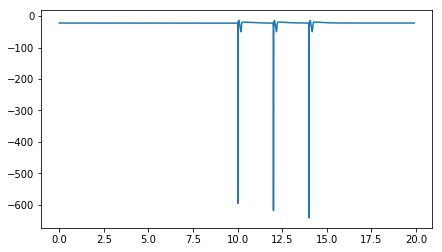

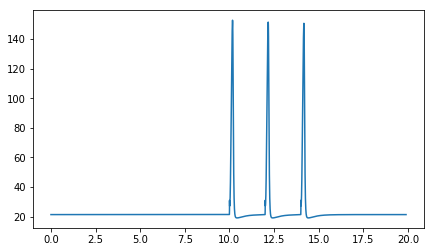

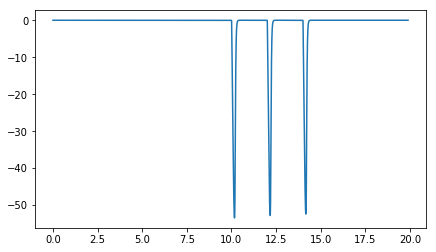

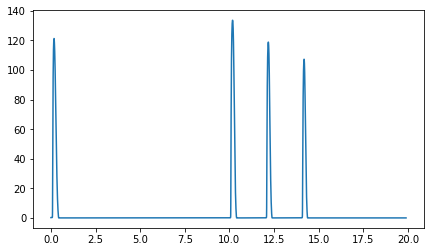

In [22]:
model.plot(model.i_ip3r(c, c_t, r, ip))
model.plot(model.i_na(v,m,h))
model.plot(model.i_k(v,n))
model.plot(model.i_cal(v, m_cal, h_cal))
model.plot(model.i_pmca(c))